# Leaf disk sheat segmentation and disk coordonates detection

## Imports

In [1]:
import os

from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
import albumentations.augmentations.functional as F
import albumentations.augmentations.geometric as G

from albumentations.pytorch import ToTensorV2

import cv2
import matplotlib.pyplot as plt
import numpy as np
import ternausnet.models
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader

## Prepare envionment

In [2]:
os.chdir(os.path.abspath(''))
os.chdir("..")
os.getcwd()

'/Users/mavi/Code/python/leafdisks_powderymildew'

In [3]:
device = "mps" if torch.backends.mps.is_built() is True else "cpu"

device

'mps'

## Constants

In [4]:
dataset_directory = os.path.join(".", "data_in", "images", "ld_sheets")


root_directory = os.path.join(dataset_directory)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "masks")


## Functions

In [5]:
def get_image(img_name):
    return cv2.cvtColor(cv2.imread(os.path.join(images_directory, img_name)), cv2.COLOR_BGR2RGB)

In [6]:
def get_mask_path(img_name):
    png_path = os.path.join(masks_directory, img_name.replace(".jpg", ".png"))
    bmp_path = os.path.join(masks_directory, img_name.replace(".jpg", ".bmp"))
    return png_path if os.path.isfile(png_path) is True else bmp_path if os.path.isfile(bmp_path) else None

In [7]:
def get_mask(img_name):
    mask_path = get_mask_path(img_name)
    if os.path.isfile(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        mask[mask == 0.0] = 0.0
        mask[mask != 0.0] = 1.0
        return mask
    else:
        return None


In [8]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title("Original image", fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title("Original mask", fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title("Transformed image", fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title("Transformed mask", fontsize=fontsize)


In [9]:
def display_image_grid(
    images_filenames,
    images_directory,
    masks_directory,
    predicted_masks=None,
):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 4 * rows))
    for i, image_filename in enumerate(images_filenames):
        image = get_image(image_filename)
        mask = get_mask(image_filename)

        assert(image is not None and mask is not None)

        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()


In [10]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose(
        [t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))]
    )
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 4 * samples))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title(f"Image {image.shape}")
        ax[i, 1].set_title(f"Mask {mask.shape}")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()


## Images

In [11]:
images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)


bad_paths = []
for cif in correct_images_filenames:
    if get_mask_path(cif) is None:
        bad_paths.append(cif)

bad_paths

[]

In [12]:
len(correct_images_filenames)

34

In [18]:
train_images_filenames = correct_images_filenames[:26]
val_images_filenames = correct_images_filenames[26:30]
test_images_filenames = correct_images_filenames[30:]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

26 4 4


In [19]:
train_images_filenames

['Exp17DM02-Inoc1-T6-P77.jpg',
 'Exp20DM02_Inoc_1_T0_P32.jpg',
 'Exp21DM12_inoc3_T4_P12.jpg',
 'Exp18DM05_T5_P67.jpg',
 'Exp22DM08_inoc1_T6_P03.jpg',
 'Exp22DM08_inoc1_T6_P07.jpg',
 'Exp19DM07_inoc1_T0_P015.jpg',
 'Exp18DM05_T0_P12.jpg',
 'Exp19DM07_inoc1_T0_P016.jpg',
 'Exp18DM05_T0_P18.jpg',
 'Exp22DM08_inoc1_T6_P05.jpg',
 'Exp18DM05_T6_P36.jpg',
 'Exp22DM08_inoc1_T6_P04.jpg',
 'Exp18DM05_T0_P10.jpg',
 'Exp18DM05_T0_P08.jpg',
 'Exp22DM08_inoc1_T6_P08.jpg',
 'Exp17DM02-Inoc1-T6-P79.jpg',
 'Exp22DM08_inoc1_T6_P01.jpg',
 'Exp16DM01-Rep1-P02.jpg',
 'Exp22DM08_inoc2_T4_P73.jpg',
 'Exp18DM05_T5_P68.jpg',
 'Exp20DM02_Inoc_1_T0_P13.jpg',
 'Exp16DM01-Rep1-P16.jpg',
 'Exp22DM08_inoc2_T4_P72.jpg',
 'Exp22DM08_inoc1_T6_P06.jpg',
 'Exp21DM12_inoc3_T4_P20.jpg']

In [20]:
val_images_filenames

['Exp17DM02-Inoc1-T6-P69.jpg',
 'Exp22DM08_inoc1_T6_P02.jpg',
 'Exp17DM02-Inoc1-T6-P76.jpg',
 'Exp22DM08_inoc1_T6_P09.jpg']

In [21]:
test_images_filenames

['Exp22DM08_inoc2_T6_P62.jpg',
 'Exp19DM07_inoc1_T0_P023.jpg',
 'Exp16DM01-Rep1-P03.jpg',
 'Exp17DM02-Inoc1-T6-P84.jpg']

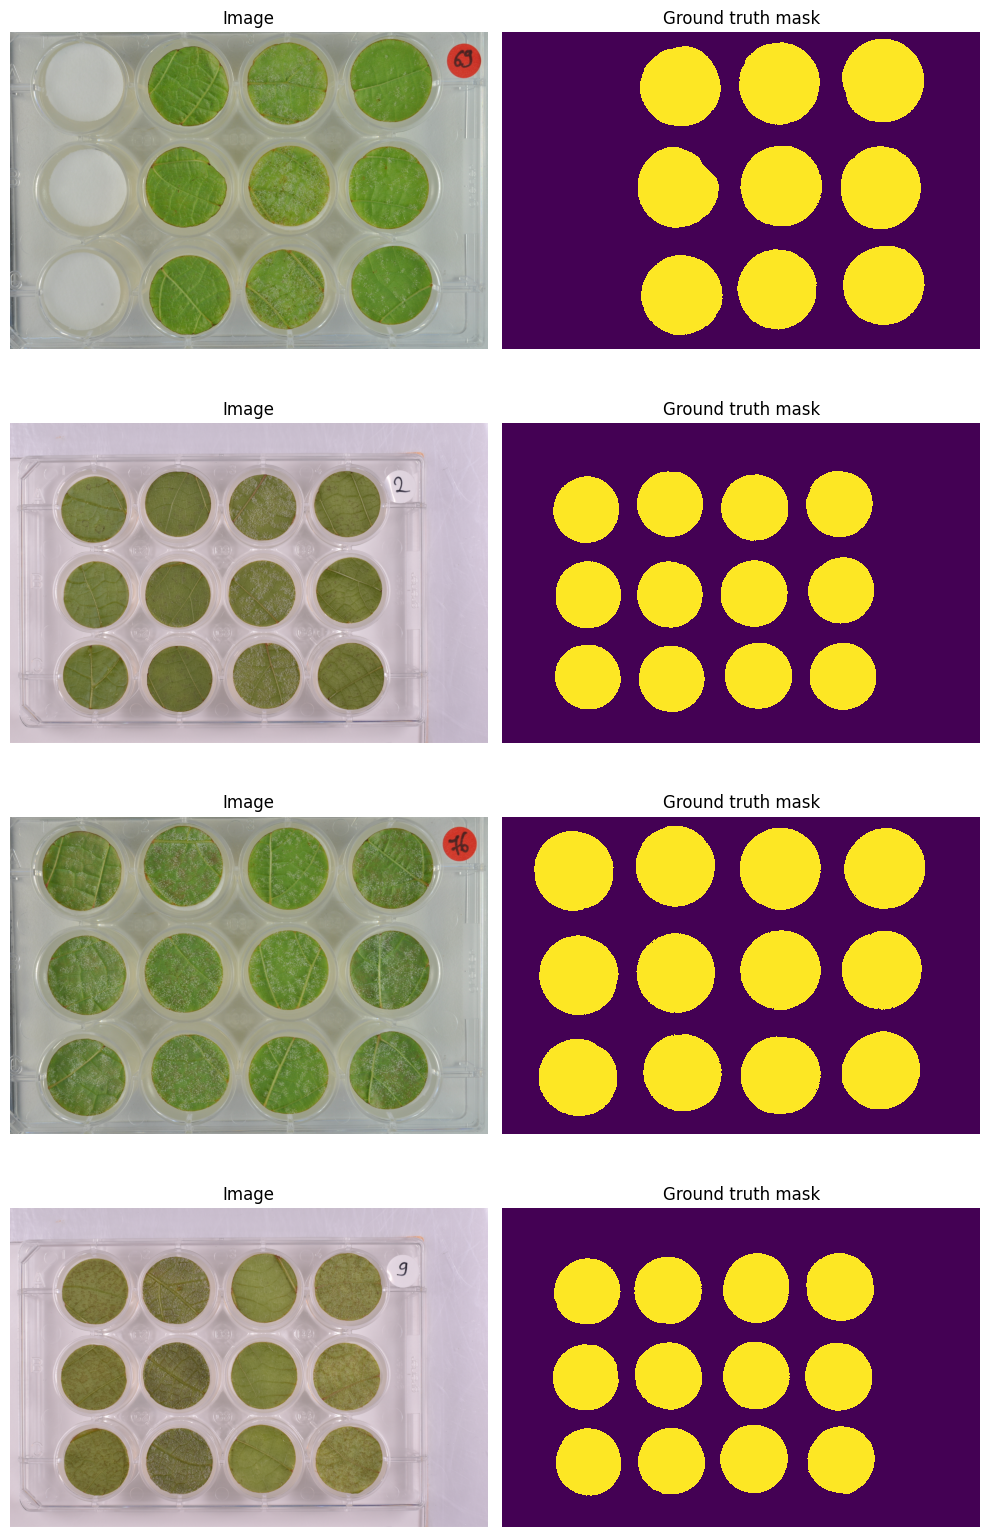

In [22]:
display_image_grid(val_images_filenames, images_directory, masks_directory)

In [23]:
correct_images_filenames

['Exp17DM02-Inoc1-T6-P77.jpg',
 'Exp20DM02_Inoc_1_T0_P32.jpg',
 'Exp21DM12_inoc3_T4_P12.jpg',
 'Exp18DM05_T5_P67.jpg',
 'Exp22DM08_inoc1_T6_P03.jpg',
 'Exp22DM08_inoc1_T6_P07.jpg',
 'Exp19DM07_inoc1_T0_P015.jpg',
 'Exp18DM05_T0_P12.jpg',
 'Exp19DM07_inoc1_T0_P016.jpg',
 'Exp18DM05_T0_P18.jpg',
 'Exp22DM08_inoc1_T6_P05.jpg',
 'Exp18DM05_T6_P36.jpg',
 'Exp22DM08_inoc1_T6_P04.jpg',
 'Exp18DM05_T0_P10.jpg',
 'Exp18DM05_T0_P08.jpg',
 'Exp22DM08_inoc1_T6_P08.jpg',
 'Exp17DM02-Inoc1-T6-P79.jpg',
 'Exp22DM08_inoc1_T6_P01.jpg',
 'Exp16DM01-Rep1-P02.jpg',
 'Exp22DM08_inoc2_T4_P73.jpg',
 'Exp18DM05_T5_P68.jpg',
 'Exp20DM02_Inoc_1_T0_P13.jpg',
 'Exp16DM01-Rep1-P16.jpg',
 'Exp22DM08_inoc2_T4_P72.jpg',
 'Exp22DM08_inoc1_T6_P06.jpg',
 'Exp21DM12_inoc3_T4_P20.jpg',
 'Exp17DM02-Inoc1-T6-P69.jpg',
 'Exp22DM08_inoc1_T6_P02.jpg',
 'Exp17DM02-Inoc1-T6-P76.jpg',
 'Exp22DM08_inoc1_T6_P09.jpg',
 'Exp22DM08_inoc2_T6_P62.jpg',
 'Exp19DM07_inoc1_T0_P023.jpg',
 'Exp16DM01-Rep1-P03.jpg',
 'Exp17DM02-Inoc1-T6-P84.j

## Albumentations

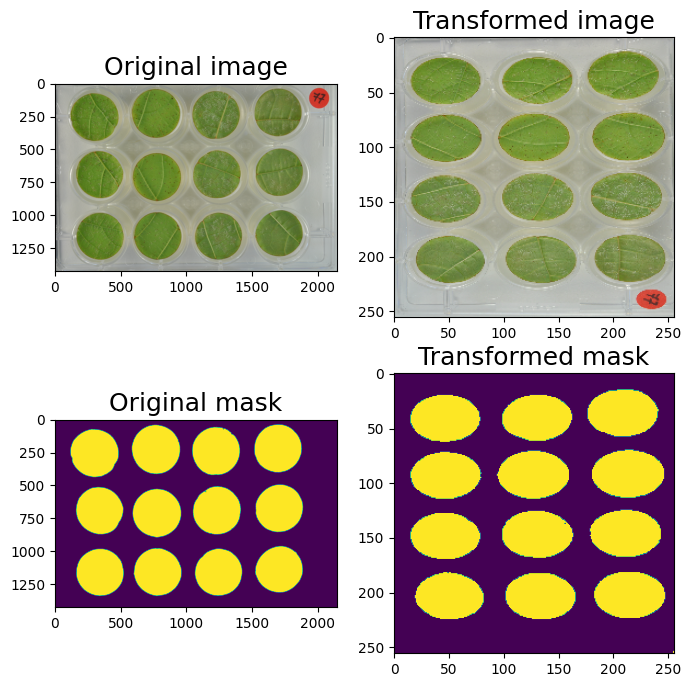

In [24]:
alb_resizer = A.Resize(height=256, width=256)

train_transformers_list = [
        alb_resizer,
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.3),
        A.RandomGamma(p=0.3),
        A.CLAHE(p=0.36),
    ]

transformer = A.Compose(train_transformers_list)


example_image_filename = correct_images_filenames[0]
image = get_image(example_image_filename)
mask = get_mask(example_image_filename)

transformed = transformer(image=image, mask=mask)

image_transformed = transformed["image"]
mask_transformed = transformed["mask"]


visualize(image_transformed, mask_transformed, original_image=image, original_mask=mask)


In [25]:
original_height, original_width, original_channel_count = image.shape

(original_width, original_height)

(2144, 1424)

In [26]:
image_transformed.shape

(256, 256, 3)

In [27]:
mask_transformed.shape

(256, 256)

In [28]:
train_transformer = A.Compose(
    train_transformers_list
    + [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ],
)

val_transformer = A.Compose(
    [
        alb_resizer,
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        alb_resizer,
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

## Datasets

In [29]:
class LeafDeafSegmentationDataset(Dataset):
    def __init__(
        self,
        images_filenames,
        images_directory,
        masks_directory,
        transform=None,
    ):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = get_image(img_name=image_filename)
        mask = get_mask(img_name=image_filename)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask


In [30]:
train_dataset = LeafDeafSegmentationDataset(
    train_images_filenames,
    images_directory,
    masks_directory,
    transform=train_transformer,
)


In [31]:
val_dataset = LeafDeafSegmentationDataset(
    val_images_filenames,
    images_directory,
    masks_directory,
    transform=val_transformer,
)


In [32]:
class LeafDeafSegmentationInferenceDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, original_size

In [33]:
test_dataset = LeafDeafSegmentationInferenceDataset(
    test_images_filenames,
    images_directory,
    transform=test_transform,
)


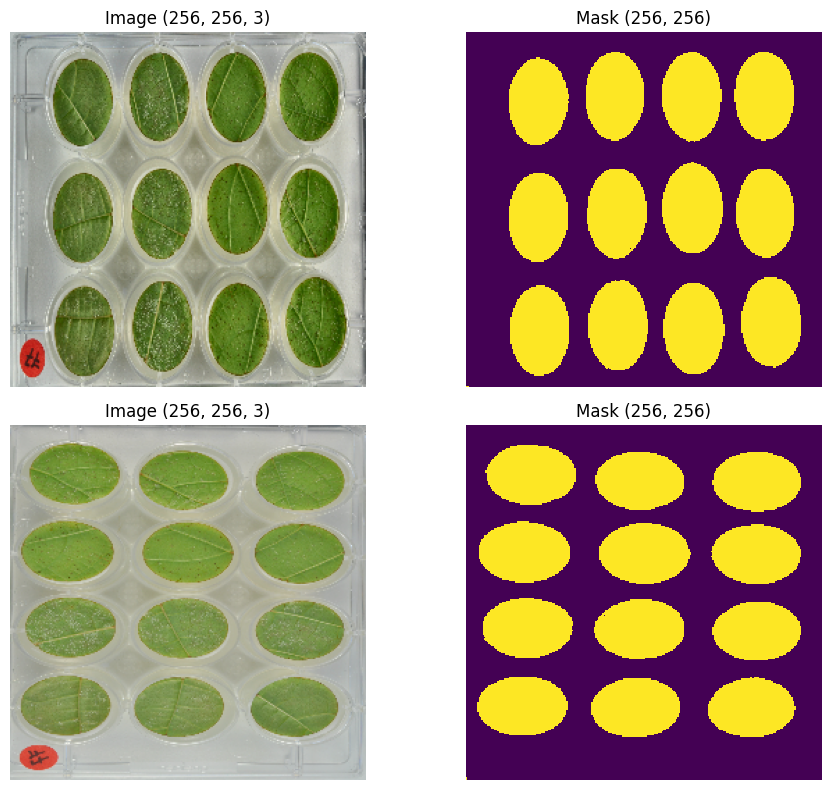

In [34]:
random.seed(42)
visualize_augmentations(train_dataset, idx=0, samples=2)

## Create and train model

In [35]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name,
                    avg=metric["avg"],
                    float_precision=self.float_precision,
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


In [36]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images).squeeze(1)
        loss = criterion(output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [37]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images).squeeze(1)
            loss = criterion(output, target)
            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [38]:
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions


In [39]:
def predict_image(img_name, model, params):
    image = get_image(img_name)
    original_height, original_width, _ = image.shape
    model.eval()
    mask = model(
        test_transform(image=image)["image"]
        .unsqueeze(0)
        .to(params["device"], non_blocking=True)
    )
    return A.resize(
        mask,
        height=original_height,
        width=original_width,
        interpolation=cv2.INTER_NEAREST,
    )


In [40]:
def train_and_validate(model, train_dataset, val_dataset, params):
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    criterion = nn.BCEWithLogitsLoss().to(params["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    for epoch in range(1, params["epochs"] + 1):
        train(train_loader, model, criterion, optimizer, epoch, params)
        validate(val_loader, model, criterion, epoch, params)
    return model

In [41]:
def create_model(params):
    model = getattr(ternausnet.models, params["model"])(pretrained=True)
    model = model.to(params["device"])
    return model

In [42]:

params = {
    "model": "UNet11",
    "device": device,
    "lr": 0.001,
    "batch_size": 3,
    "num_workers": 0,
    "epochs": 20,
}

In [43]:

model = create_model(params)
model = train_and_validate(model, train_dataset, val_dataset, params)

/Users/mavi/Code/python/leafdisks_powderymildew/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/mavi/Code/python/leafdisks_powderymildew/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch: 20. Validation. Loss: 0.031: 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


## Test model

In [44]:
predictions = predict(model, params, test_dataset, batch_size=16)

In [45]:
predicted_masks = []
for predicted_256x256_mask, original_height, original_width in predictions:
    full_sized_mask = A.resize(
        predicted_256x256_mask,
        height=original_height,
        width=original_width,
        interpolation=cv2.INTER_NEAREST,
    )
    predicted_masks.append(full_sized_mask)


libpng warning: iCCP: known incorrect sRGB profile


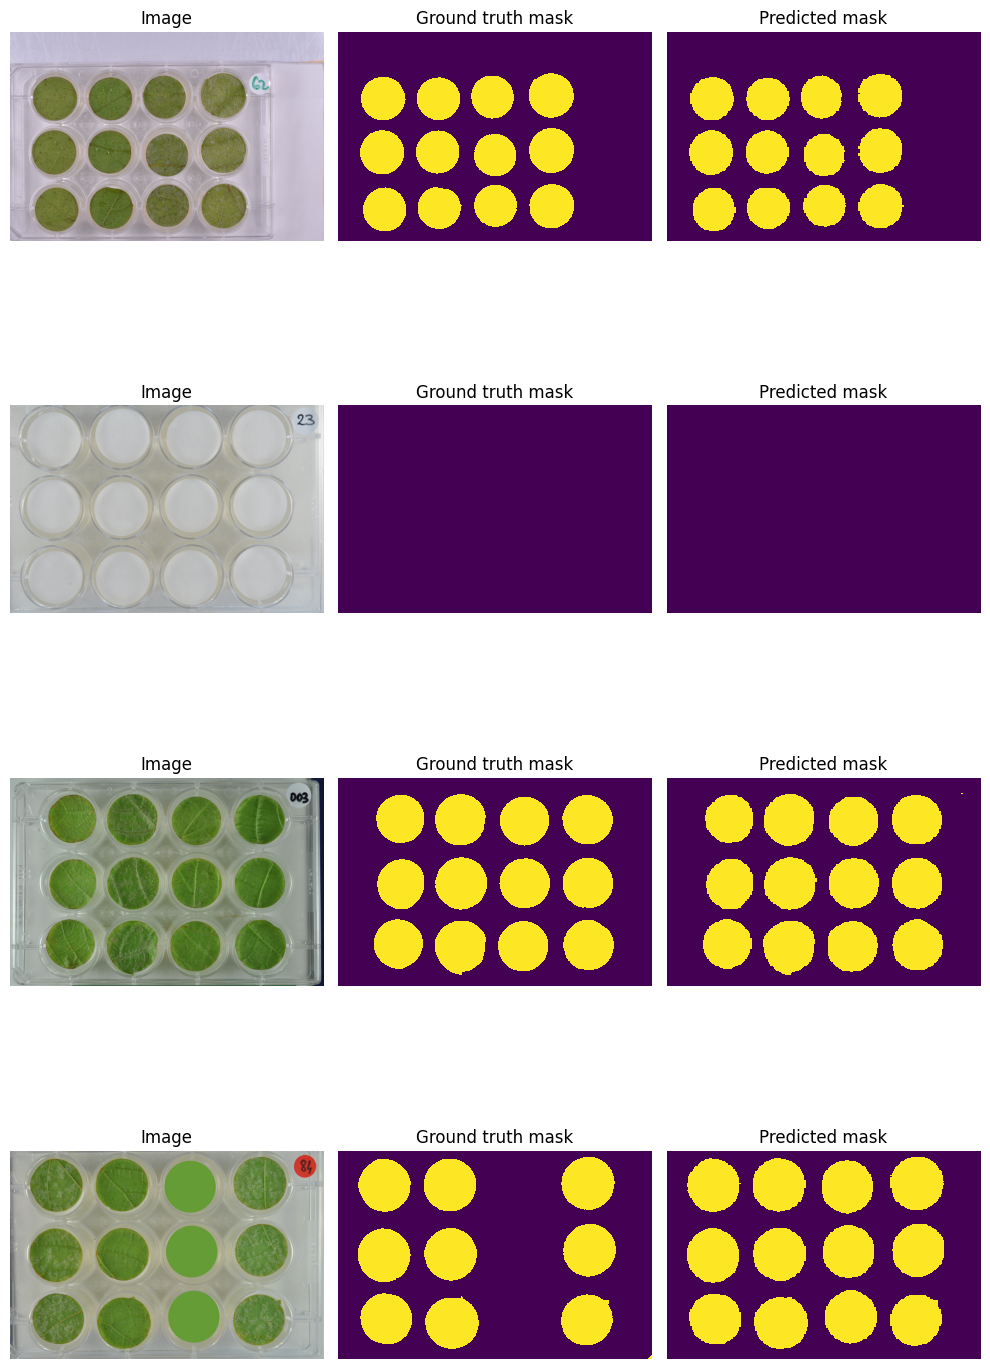

In [46]:
display_image_grid(test_images_filenames, images_directory, masks_directory, predicted_masks=predicted_masks)

In [ ]:
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=params["num_workers"],
    pin_memory=True,
)

In [ ]:
model.eval()
model(test_transform(image=get_image(test_images_filenames[0]))["image"].unsqueeze(0).to(params["device"], non_blocking=True))


In [ ]:
image = get_image(test_images_filenames[0])
original_height, original_width, _ = image.shape
model.eval()
output = model(
    test_transform(image=image)["image"]
    .unsqueeze(0)
    .to(params["device"], non_blocking=True)
)

probabilities = torch.sigmoid(output.squeeze(1))
predicted_masks = (probabilities >= 0.5).float() * 1
predicted_masks = predicted_masks.cpu().numpy()

mask = predicted_masks.squeeze(0)

mask.shape

# mask = A.resize(
#     mask,
#     height=original_height,
#     width=original_width,
#     interpolation=cv2.INTER_NEAREST,
# )
# # predicted_masks.squeeze(0).shape
# plt.imshow(mask)
plt.imshow(output.squeeze(0).squeeze(0).cpu().detach().numpy())
# plt.imshow(output.squeeze(0).cpu().detach().numpy())
# output.squeeze(0).shape